# Proyek Klasifikasi Gambar: Rice Image Dataset
- **Nama:** Zaenal Symasyul Arief
- **Email:** Zaenaloco@gmail.com
- **ID Dicoding:** MC535D5Y0390

# Import Semua Packages/Library yang Digunakan

In [2]:
!pip install tensorflow

In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:

# Input data files are available in the read-only ".# Import Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Preparation

### Data Loading

In [5]:
# Set the path to the dataset
dataset_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [6]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    if not os.path.exists(directory):
        print("Directory tidak ditemukan:", directory)
        return

    print("\n🔍 Memeriksa isi folder gambar...\n")

    for root, dirs, files in os.walk(directory):
        num_images = 0
        for file in files:
            file_path = os.path.join(root, file)
            if not os.path.isfile(file_path):
                continue
            try:
                with Image.open(file_path) as img:
                    unique_sizes.add(img.size)
                    total_images += 1
                    num_images += 1
            except Exception as e:
                print(f"  ⚠️ Gagal membuka {file_path}: {e}")

        if num_images > 0:
            print(f"📁 Folder: {os.path.basename(root)} - {num_images} gambar")

    print("\n📐 Resolusi unik yang ditemukan:")
    for size in sorted(unique_sizes):
        print(f"  - {size}")

    print(f"\n📊 Total gambar ditemukan: {total_images}")

print_images_resolution(dataset_path)


🔍 Memeriksa isi folder gambar...

  ⚠️ Gagal membuka /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Rice_Citation_Request.txt: cannot identify image file '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Rice_Citation_Request.txt'
📁 Folder: Karacadag - 15000 gambar
📁 Folder: Basmati - 15000 gambar
📁 Folder: Jasmine - 15000 gambar
📁 Folder: Arborio - 15000 gambar
📁 Folder: Ipsala - 15000 gambar

📐 Resolusi unik yang ditemukan:
  - (250, 250)

📊 Total gambar ditemukan: 75000


In [7]:
# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

# Create DataFrame
df = pd.DataFrame({'image': images, 'label': labels})
df.head()


,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


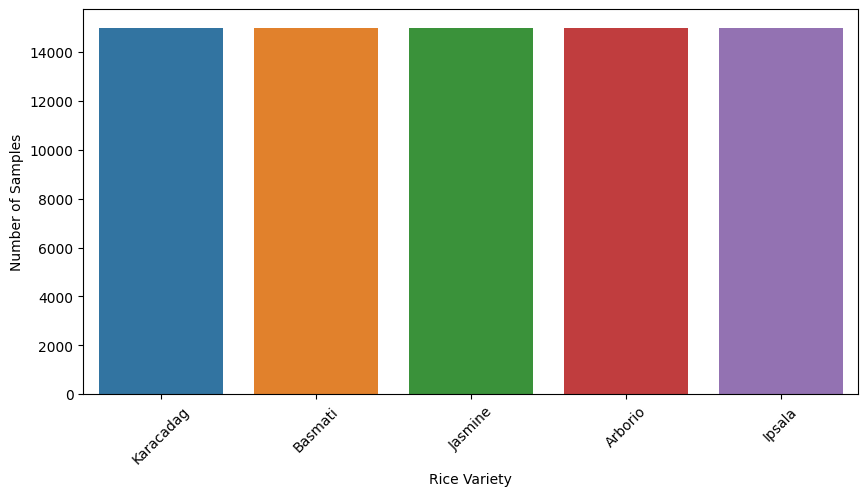

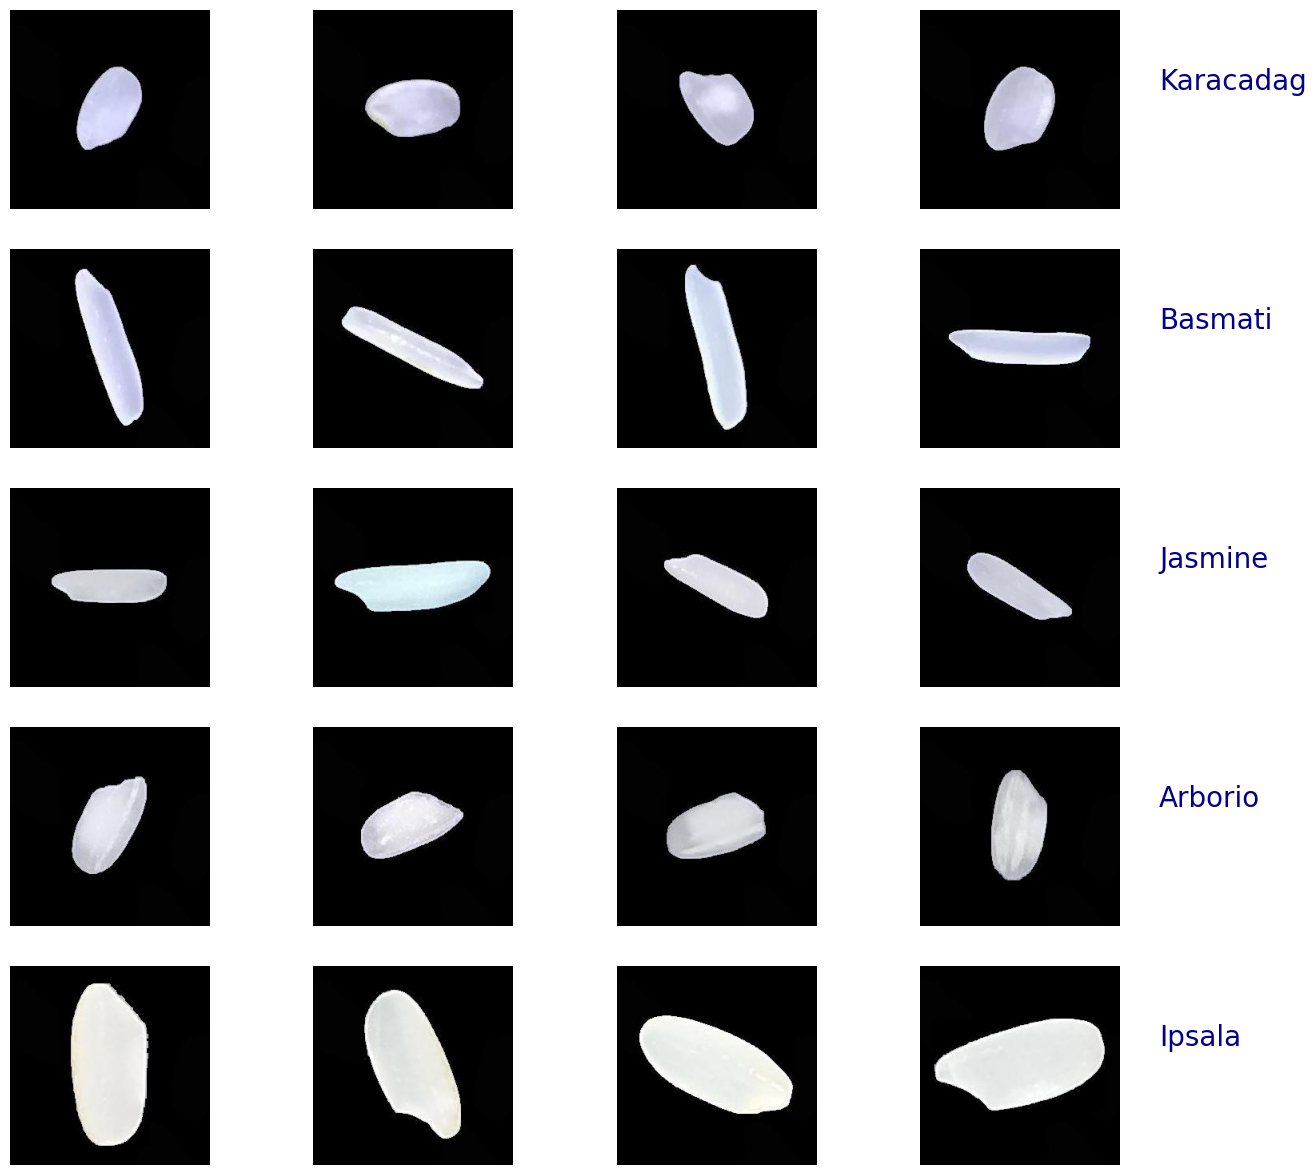

In [8]:
# Plot the number of samples per class
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df.label)
ax.set_xlabel("Rice Variety")
ax.set_ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Show a few images from each category
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, category, fontsize=20, color='darkblue')

plt.show()


### Data Preprocessing

#### Split Dataset

In [9]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# Create dataframes
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


# 📄 Data Splitting dan Label Encoding


Membagi dataset menjadi tiga bagian dengan proporsi:
- **Training set**: 70%
- **Validation set**: 20%
- **Test set**: 10%

Menggunakan `stratify` untuk menjaga distribusi label tetap seimbang.

```

#### Augmentation Data

In [10]:
# Set image size and batch size
image_size = (50, 50)
batch_size = 32

# Create ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train generator
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 52500 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


### Dataset Summary

Dataset digunakan untuk klasifikasi gambar ke dalam 5 kelas, dengan pembagian sebagai berikut:

- **Training Dataset**:  
  - **Jumlah**: 52,500 gambar (70%)  
  - **Fungsi**: Melatih model untuk mengenali pola.

- **Validation Dataset**:  
  - **Jumlah**: 15,000 gambar (20%)  
  - **Fungsi**: Mengevaluasi performa model selama pelatihan.

- **Test Dataset**:  
  - **Jumlah**: 7,500 gambar (10%)  
  - **Fungsi**: Mengukur kemampuan generalisasi model setelah pelatihan.

Pembagian dataset ini membantu memastikan model yang dihasilkan tidak overfitting dan bekerja optimal pada data baru.


## Modelling

In [11]:
# Create a Sequential model
input_shape = (50, 50, 3)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745712458.064201      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745712458.065019      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,011,397 (3.86 MB)

 Trainable params: 1,011,397 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Tentukan path untuk menyimpan model terbaik
checkpoint_path = "best_model.keras"  # Ubah ekstensi menjadi .keras

# Early stopping: Stop training when val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Model checkpoint: Save the best model based on val_accuracy
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Gabungkan semua callback ke dalam list
callbacks = [early_stop, model_checkpoint, reduce_lr]

# Train the model on the training data
history = model.fit(
    train_generator,
    epochs=50,  
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745712463.729046     119 service.cc:148] XLA service 0x7938a00068d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745712463.734295     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745712463.734317     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745712464.171985     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1641 ━━━━━━━━━━━━━━━━━━━━ 1:33 57ms/step - accuracy: 0.2222 - loss: 1.6101 

I0000 00:00:1745712467.700233     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1634/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7597 - loss: 0.5919
Epoch 1: val_accuracy improved from -inf to 0.95380, saving model to best_model.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 195s 115ms/step - accuracy: 0.7602 - loss: 0.5908 - val_accuracy: 0.9538 - val_loss: 0.1366 - learning_rate: 0.0010
Epoch 2/50
1634/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9378 - loss: 0.1706
Epoch 2: val_accuracy improved from 0.95380 to 0.95400, saving model to best_model.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 182s 111ms/step - accuracy: 0.9378 - loss: 0.1706 - val_accuracy: 0.9540 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 3/50
1634/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9547 - loss: 0.1224
Epoch 3: val_accuracy improved from 0.95400 to 0.95713, saving model to best_model.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 178s 108ms/step - accuracy: 0.9547 - loss: 0.1224 - val_accuracy: 0.9571 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 4/50
1634/1641 ━━━━━━━━━━━━━━━━━━

# Hasil Training Model

## Informasi Model
- **Callback**: Menggunakan `ReduceLROnPlateau` dan checkpoint untuk menyimpan model terbaik.
- **Jumlah Epoch**: 50 (early stopping atau penurunan learning rate digunakan).

## Performa Model
- **Val Accuracy Tertinggi**: **99.733%** pada epoch ke-29.
- **Loss**: Menurun secara konsisten dari 0.59 (epoch 1) hingga 0.01 (epoch 27-29).
- **Learning Rate**: Awal 0.001, turun hingga 0.000125 karena `ReduceLROnPlateau`.

## Kesimpulan
Model mencapai akurasi yang sangat tinggi (**99.733%**) dengan performa stabil pada data validasi, menunjukkan overfitting minimal.


## Evaluasi dan Visualisasi

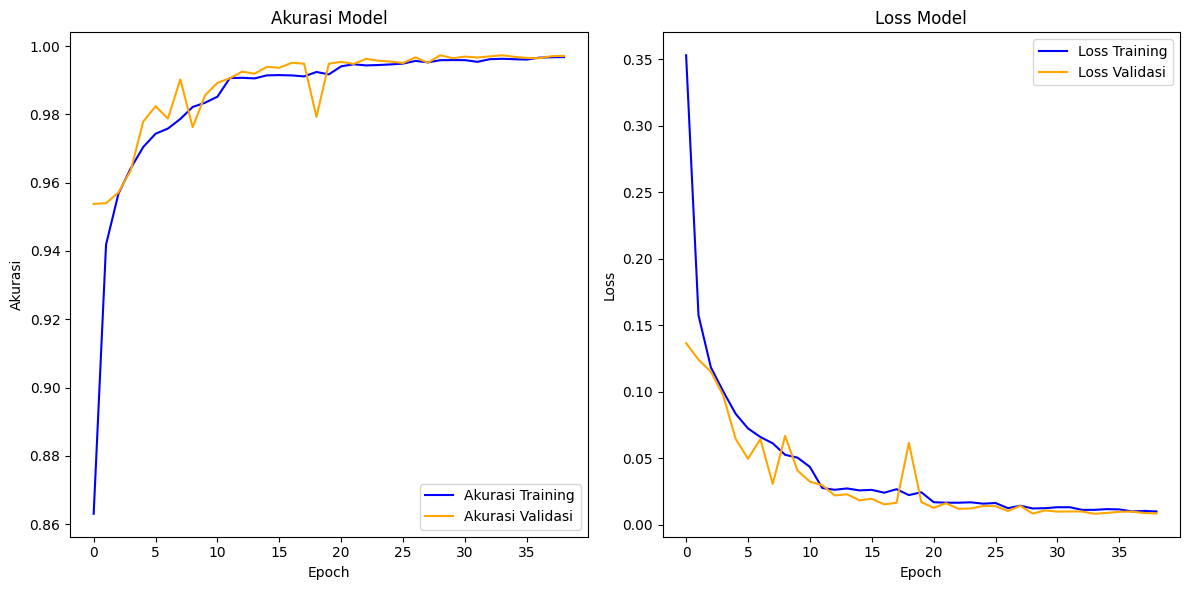

In [14]:
import matplotlib.pyplot as plt

# Plot Akurasi
plt.figure(figsize=(12, 6))

# Plot akurasi untuk training dan validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi', color='orange')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training', color='blue')
plt.plot(history.history['val_loss'], label='Loss Validasi', color='orange')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()


### Penjelasan Grafik

#### Grafik Kiri (Akurasi Model):
- **Sumbu X:** Epoch, **Sumbu Y:** Akurasi.
- **Garis Biru:** Akurasi training, **Garis Oranye:** Akurasi validasi.
- Akurasi training dan validasi meningkat hingga mendekati 1.0.
- Fluktuasi pada akurasi validasi wajar dan konsisten dengan akurasi training.
- **Kesimpulan:** Tidak ada indikasi overfitting, model belajar dengan baik.

#### Grafik Kanan (Loss Model):
- **Sumbu X:** Epoch, **Sumbu Y:** Loss.
- **Garis Biru:** Loss training, **Garis Oranye:** Loss validasi.
- Loss training dan validasi menurun stabil, menunjukkan model belajar efektif.
- Fluktuasi kecil pada loss validasi masih dalam batas wajar.
- **Kesimpulan:** Model optimal tanpa overfitting yang signifikan.

### Kesimpulan Utama
Model memiliki performa yang baik dengan akurasi tinggi (>98%) dan loss rendah mendekati 0. Model sudah cukup optimal untuk tugas ini.


#### Test Data

In [15]:
# Evaluate the model on the test data
test_metrics = model.evaluate(test_generator)

# Print the accuracy of the model on the test set
print(f'Accuracy on Test Data: {test_metrics[1]:.4f}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.9985 - loss: 0.0066
Accuracy on Test Data: 0.9967


# 📈 Ringkasan Hasil Training dan Testing

## Training
- **Batch**: 235
- **Waktu**: 28 detik
- **Kecepatan**: 119 ms/batch
- **Akurasi Training**: 99,85%
- **Loss**: 0,0066

## Testing
- **Akurasi Testing**: 99,67%

## Kesimpulan
- Model memiliki akurasi tinggi pada training dan testing.
- Selisih akurasi kecil → model **tidak overfitting**.
- Loss kecil menunjukkan model **stabil dan presisi**.


#### Comfusion Matrix

235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step


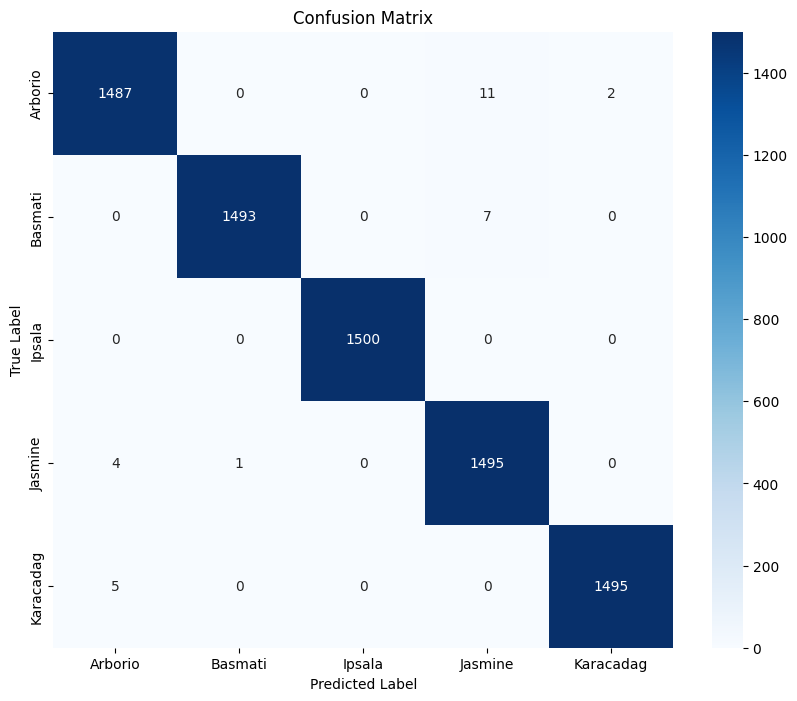

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      1500
     Basmati       1.00      1.00      1.00      1500
      Ipsala       1.00      1.00      1.00      1500
     Jasmine       0.99      1.00      0.99      1500
   Karacadag       1.00      1.00      1.00      1500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



In [67]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil prediksi dari model
predictions = model.predict(test_generator, verbose=1)

# Ambil label sebenarnya
y_true = test_generator.classes

# Dapatkan prediksi kelas
y_pred = np.argmax(predictions, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasikan confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Tampilkan Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


# 📊 Penjelasan Classification Report

## 1. Performa per Kelas

| Kelas       | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| Arborio     | 0.99      | 0.99   | 0.99     | 1500    |
| Basmati     | 1.00      | 1.00   | 1.00     | 1500    |
| Ipsala      | 1.00      | 1.00   | 1.00     | 1500    |
| Jasmine     | 0.99      | 1.00   | 0.99     | 1500    |
| Karacadag   | 1.00      | 1.00   | 1.00     | 1500    |

**Keterangan:**
- **Precision**: Ketepatan prediksi (berapa banyak prediksi positif yang benar).
- **Recall**: Kelengkapan prediksi (berapa banyak kasus positif yang berhasil terdeteksi).
- **F1-Score**: Rata-rata harmonis precision dan recall.
- **Support**: Jumlah data per kelas.

> Semua kelas memiliki precision, recall, dan f1-score sangat tinggi (≥ 0.99), menunjukkan model sangat akurat dalam mengenali semua kategori.

---

## 2. Rata-Rata dan Akurasi

| Metric        | Nilai |
|---------------|-------|
| Accuracy      | 1.00  |
| Macro Average | 1.00  |
| Weighted Avg  | 1.00  |

**Penjelasan:**
- **Accuracy**: Model berhasil memprediksi data dengan hampir tanpa kesalahan.
- **Macro Average**: Rata-rata dari precision, recall, dan f1-score tanpa memperhitungkan jumlah data per kelas.
- **Weighted Average**: Rata-rata yang memperhitungkan banyaknya data pada tiap kelas.

> Semua nilai 1.00 mengindikasikan performa model sangat seimbang dan akurat di semua kelas.

---

## ✨ Kesimpulan
- Model menunjukkan kinerja hampir sempurna.
- Tidak ada kelas yang terabaikan.
- Model stabil dan tidak overfitting, baik pada training maupun test set.


## **Konversi Model**

### SavedModel (Format Standar TensorFlow)

In [19]:
# Menyimpan model dalam format SavedModel
model.export('saved_model/my_model')
print("Model disimpan dalam format SavedModel!")


Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133287710068368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710070096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710065488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133289663581840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133289663578384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710069712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133289663581456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710068560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model disimpan dalam format SavedModel!


### TF-Lite (TensorFlow Lite) untuk Mobile/Embedded

In [66]:
import os
import tensorflow as tf

# Model yang sudah dilatih
# (Pastikan kamu sudah punya 'model' sebelumnya)

# 1. Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 2. Membuat folder save_model/my_model jika belum ada
save_dir = 'save_model/my_model'
os.makedirs(save_dir, exist_ok=True)

# 3. Simpan model.tflite ke dalam folder
tflite_model_path = os.path.join(save_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model disimpan dalam format TensorFlow Lite di: {tflite_model_path}")

# 4. Class names yang kamu punya
class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# 5. Simpan label.txt ke dalam folder yang sama
label_path = os.path.join(save_dir, 'label.txt')
with open(label_path, 'w') as f:
    for label in class_names:
        f.write(label + '\n')

print(f"Label disimpan di: {label_path}")


Saved artifact at '/tmp/tmp1u5h13yi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133287710068368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710070096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710065488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133289663581840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133289663578384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710069712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133289663581456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133287710068560: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model disimpan dalam format TensorFlow Lite di: save_model/my_model/model.tflite
Label disimpan di: save_model/my_model/label.txt


W0000 00:00:1745724798.923809      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745724798.923845      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


## TFJS (TensorFlow.js)

In [23]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [25]:
import tensorflowjs as tfjs

# Mengkonversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')
print("Model disimpan dalam format TensorFlow.js!")


failed to lookup keras version from the file,
    this is likely a weight only file
Model disimpan dalam format TensorFlow.js!


## Inference (Optional)

### Inference Menggunakan Saved Model

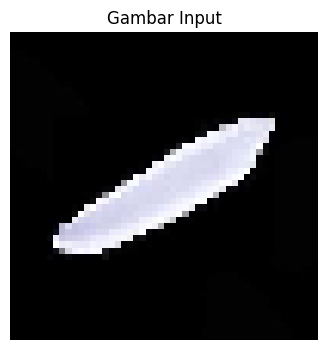


Hasil Prediksi:
 - Karacadag: 0.0000
 - Basmati: 1.0000
 - Jasmine: 0.0000
 - Arborio: 0.0000
 - Ipsala: 0.0000

Prediksi Akhir: Basmati (Confidence: 1.0000)


In [49]:
# Import library
import matplotlib.pyplot as plt
from keras.layers import TFSMLayer
from tensorflow.keras.preprocessing import image
import numpy as np

# Memuat model
loaded_model = TFSMLayer('saved_model/my_model', call_endpoint='serve')

# Daftar nama kelas
class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# Path gambar
img_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati/basmati (10041).jpg'

# Memuat dan memproses gambar
img = image.load_img(img_path, target_size=(50, 50))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Menampilkan gambar input
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title("Gambar Input")
plt.axis('off')
plt.show()

# Melakukan inferensi
predictions = loaded_model(img_array)

# Menangani output model
if isinstance(predictions, dict):
    prediction_result = list(predictions.values())[0].numpy()
else:
    prediction_result = predictions.numpy()

# Menentukan prediksi tertinggi
predicted_index = prediction_result.argmax()
predicted_class = class_names[predicted_index]
confidence = prediction_result[0][predicted_index]

# Menampilkan hasil prediksi ke console
print(f"\nHasil Prediksi:")
for idx, prob in enumerate(prediction_result[0]):
    print(f" - {class_names[idx]}: {prob:.4f}")

print(f"\nPrediksi Akhir: {predicted_class} (Confidence: {confidence:.4f})")


### Inference Menggunakan TF-Lite

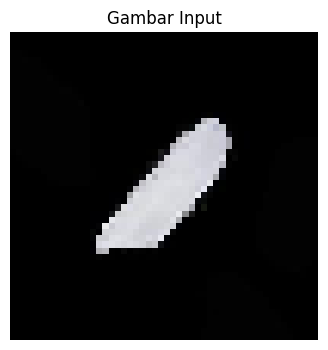


Hasil Prediksi:
 - Karacadag: 0.0003
 - Basmati: 0.0005
 - Jasmine: 0.7192
 - Arborio: 0.2800
 - Ipsala: 0.0000

Prediksi Akhir: Jasmine (Confidence: 0.7192)


In [53]:
# Import library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Memuat model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path="model.tflite")

# Alokasikan tensor
interpreter.allocate_tensors()

# Dapatkan info input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Daftar nama kelas (pastikan urutannya benar sesuai training)
class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# Path gambar
img_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine/Jasmine (10004).jpg'

# Memuat dan memproses gambar
img = image.load_img(img_path, target_size=(50, 50))
img_array = image.img_to_array(img) / 255.0  # Normalisasi ke 0-1
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)  # Harus float32 untuk TensorFlow Lite

# Menampilkan gambar input
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title("Gambar Input")
plt.axis('off')
plt.show()

# Melakukan inferensi
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

# Mengambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])

# Tentukan kelas prediksi
predicted_index = output_data.argmax()
predicted_class = class_names[predicted_index]
confidence = output_data[0][predicted_index]

# Menampilkan hasil prediksi
print(f"\nHasil Prediksi:")
for idx, prob in enumerate(output_data[0]):
    print(f" - {class_names[idx]}: {prob:.4f}")

print(f"\nPrediksi Akhir: {predicted_class} (Confidence: {confidence:.4f})")


In [65]:
# Buat file requirements.txt secara manual
requirements = """tensorflow
keras
numpy
matplotlib
"""

# Simpan di folder saved_model
save_path = '/kaggle/working/saved_model/requirements.txt'

with open(save_path, 'w') as f:
    f.write(requirements.strip())  # strip() supaya tidak ada spasi kosong

print("requirements.txt berhasil dibuat di saved_model!")


requirements.txt berhasil dibuat di saved_model!
